# Benchmark Results Inspector

This notebook provides tools to inspect and analyze benchmark results from language model evaluations.

In [14]:
import json

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML, Markdown, display, Pretty
from ipywidgets import HBox, Layout, VBox


## Load and Parse Benchmark Results

First, we need to load the benchmark results from a JSON file. Each line in the file is a separate JSON object representing a benchmark result.

In [2]:
def load_results(file_path):
    """
    Load benchmark results from a JSONL file directly into a list of dictionaries.
    """
    # Read the JSONL file line by line
    results = []
    with open(file_path, "r") as f:
        for line in f:
            results.append(json.loads(line))

    return results


def preprocess(result):
    """
    Process a single benchmark result.

    Args:
        result: A single result dictionary
        doc_id: The document ID to assign

    Returns:
        A flattened result dictionary
    """
    # Create flattened result
    flattened_result = {
        "doc_id": result["doc_id"],
        "question": result["doc"]["question"],
        "answer": result["doc"].get("answer", ""),
        "target": result["target"],
        "model_response": result["resps"][0][0]
        if result["resps"] and result["resps"][0]
        else "",
        "filtered_response": result["filtered_resps"][0]
        if result["filtered_resps"]
        else "",
        "exact_match": result["exact_match"],
        "full_result": result,  # Keep the full result for reference
    }

    return flattened_result


def load_and_process_results(file_path):
    """
    Load benchmark results from a JSONL file directly into a list of dictionaries
    and process it for analysis.
    """
    # Merge loading and processing in one function
    return [preprocess(result) for result in load_results(file_path)]

In [3]:
# Example usage:
file_path = '../outputs/Meta-Llama-3-8B-Instruct-GRPO/samples_gsm8k_grpo_2025-02-28T09-58-02.987651.jsonl'
df = pd.DataFrame(load_and_process_results(file_path))
print(df.dtypes)
df.head()

doc_id                 int64
question              object
answer                object
target                object
model_response        object
filtered_response     object
exact_match          float64
full_result           object
dtype: object


,doc_id,question,answer,target,model_response,filtered_response,exact_match,full_result
0,0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,18,<think>\n\nJanet's ducks lay 16 eggs per day. ...,18,1.0,"{'doc_id': 0, 'doc': {'question': 'Janet’s duc..."
1,1,A robe takes 2 bolts of blue fiber and half th...,It takes 2/2=<<2/2=1>>1 bolt of white fiber\nS...,3,<think>\n\nLet's start by identifying the amou...,[invalid],0.0,"{'doc_id': 1, 'doc': {'question': 'A robe take..."
2,2,Josh decides to try flipping a house. He buys...,The cost of the house and repairs came out to ...,70000,<think>\n\nLet's start by finding the value of...,"-$10,000",0.0,"{'doc_id': 2, 'doc': {'question': 'Josh decide..."
3,3,James decides to run 3 sprints 3 times a week....,He sprints 3*3=<<3*3=9>>9 times\nSo he runs 9*...,540,<think>\n\nJames runs 3 sprints 3 times a week...,540,1.0,"{'doc_id': 3, 'doc': {'question': 'James decid..."
4,4,"Every day, Wendi feeds each of her chickens th...","If each chicken eats 3 cups of feed per day, t...",20,<think>\n\nWendi gives her chickens 15 cups of...,20,1.0,"{'doc_id': 4, 'doc': {'question': 'Every day, ..."


In [4]:
with open('flat-results.jsonl', 'w') as f:
    df[['doc_id', 'question', 'answer', 'target', 'model_response', 'filtered_response', 'exact_match']].to_json(f, orient='records', lines=True)

## Analyze Results

Let's analyze the benchmark results to get an overview of the performance.

Total examples: 2638
Correct examples: 1864
Accuracy: 70.66%


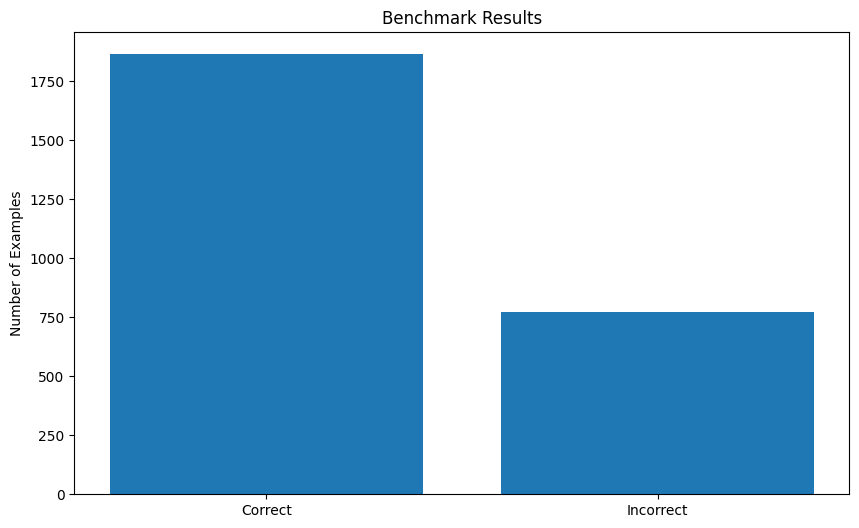

In [5]:
def analyze_results(df):
    """
    Analyze benchmark results and display summary statistics.
    """
    total_examples = len(df)
    correct_examples = df[df['exact_match'] == 1.0].shape[0]
    accuracy = correct_examples / total_examples if total_examples > 0 else 0
    
    print(f"Total examples: {total_examples}")
    print(f"Correct examples: {correct_examples}")
    print(f"Accuracy: {accuracy:.2%}")
    
    # Plot accuracy
    plt.figure(figsize=(10, 6))
    plt.bar(['Correct', 'Incorrect'], [correct_examples, total_examples - correct_examples])
    plt.title('Benchmark Results')
    plt.ylabel('Number of Examples')
    plt.show()
    
    return {
        'total_examples': total_examples,
        'correct_examples': correct_examples,
        'accuracy': accuracy
    }

# Analyze sample results
analysis = analyze_results(df)

## Interactive Result Browser

Let's create an interactive browser to inspect individual benchmark results.

In [19]:
import textwrap

def format_text(text):
    return '\n'.join(textwrap.wrap(text, width=120))


def present_row(row):
    """
    Display a single benchmark result in a readable format.
    """
    display(HTML(f"<h3>Example {row['doc_id']} {' - ✓ Correct' if row['exact_match'] == 1.0 else ' - ✗ Incorrect'}</h3>"))
    
    # Question
    display(HTML(f"<h4>Question:</h4>"))
    question = format_text(row['question'])
    display(Markdown(f"{question}"))
    
    # Reference answer (if available)
    display(HTML(f"<h4>Answer:</h4>"))
    # Limit text width to 120 characters
    ref_answer = '\n'.join(textwrap.wrap(row['answer'], width=120))
    display(Markdown(f"{ref_answer}"))
    
    # Target answer
    display(HTML(f"<h4>Target Answer:</h4>"))
    display(Markdown(f"{row['target']}"))

    # Model response
    display(HTML(f"<h4>Model Response:</h4>"))
    model_response = '\n'.join(textwrap.wrap(row['model_response'], width=120))
    display(Pretty(f"{model_response}"))
    
    # Model answer
    display(HTML(f"<h4>Model Answer:</h4>"))
    model_answer = format_text(row['filtered_response'])
    display(Markdown(f"{model_answer}"))

def create_browse_app(df):
    """
    Create an interactive app to browse through benchmark results.
    """
    def browse_results(i=0, show_correct=False, show_incorrect=True):
        filtered_df = df.copy()
        if not show_correct:
            filtered_df = filtered_df[filtered_df['exact_match'] != 1.0]
        if not show_incorrect:
            filtered_df = filtered_df[filtered_df['exact_match'] == 1.0]
        
        if len(filtered_df) == 0:
            display(HTML("<h3>No examples match the current filters</h3>"))
            return
        
        # Ensure index is within bounds
        i = max(0, min(i, len(filtered_df) - 1))
        row = filtered_df.iloc[i]
        present_row(row)
        
        # Display pagination info
        display(HTML(f"<p>Showing example {i+1} of {len(filtered_df)}</p>"))

    # Create widgets
    index = widgets.IntText(
        value=0, 
        description='Index:', 
        min=0, 
        max=len(df)-1
    )
    left_button = widgets.Button(description='Previous')
    right_button = widgets.Button(description='Next')
    show_correct = widgets.Checkbox(value=False, description='Show Correct')
    show_incorrect = widgets.Checkbox(value=True, description='Show Incorrect')
    
    # Define button callbacks
    def on_left_button_clicked(b):
        if index.value > 0:
            index.value -= 1

    def on_right_button_clicked(b):
        if index.value < len(df) - 1:
            index.value += 1

    left_button.on_click(on_left_button_clicked)
    right_button.on_click(on_right_button_clicked)

    # Create UI layout
    navigation = HBox([left_button, index, right_button])
    filters = HBox([show_correct, show_incorrect])
    ui = VBox([navigation, filters])
    
    # Create interactive output
    out = widgets.interactive_output(
        browse_results, 
        {
            'i': index, 
            'show_correct': show_correct, 
            'show_incorrect': show_incorrect
        }
    )

    display(ui, out)
    
# Create and display the interactive browser
create_browse_app(df)

Output()

## Filter and Search Results

Let's add functionality to filter and search through the benchmark results.

In [7]:
def create_search_app(df):
    """
    Create an interactive app to search and filter benchmark results.
    """
    def search_results(search_query='', show_correct=True, show_incorrect=True):
        filtered_df = df.copy()
        
        # Apply correctness filters
        if not show_correct:
            filtered_df = filtered_df[filtered_df['exact_match'] != 1.0]
        if not show_incorrect:
            filtered_df = filtered_df[filtered_df['exact_match'] == 1.0]
        
        # Apply search query
        if search_query:
            query_lower = search_query.lower()
            mask = (
                filtered_df['question'].str.lower().str.contains(query_lower, na=False) | 
                filtered_df['reference_answer'].str.lower().str.contains(query_lower, na=False) | 
                filtered_df['model_response'].str.lower().str.contains(query_lower, na=False) | 
                filtered_df['filtered_response'].str.lower().str.contains(query_lower, na=False)
            )
            filtered_df = filtered_df[mask]
        
        # Display results
        display(HTML(f"<h3>Found {len(filtered_df)} matching examples</h3>"))
        
        if len(filtered_df) > 0:
            # Display a summary table
            summary_df = filtered_df[['doc_id', 'question', 'filtered_response', 'target', 'exact_match']].copy()
            summary_df['correct'] = summary_df['exact_match'].apply(lambda x: '✓' if x == 1.0 else '✗')
            display(summary_df[['doc_id', 'question', 'filtered_response', 'target', 'correct']])
        
        return filtered_df
    
    # Create widgets
    search_box = widgets.Text(value='', placeholder='Search in questions and answers...', description='Search:')
    show_correct = widgets.Checkbox(value=True, description='Show Correct')
    show_incorrect = widgets.Checkbox(value=True, description='Show Incorrect')
    search_button = widgets.Button(description='Search')
    
    # Create UI layout
    search_bar = HBox([search_box, search_button])
    filters = HBox([show_correct, show_incorrect])
    ui = VBox([search_bar, filters])
    
    # Create output area
    output = widgets.Output()
    
    # Define search button callback
    def on_search_button_clicked(b):
        output.clear_output()
        with output:
            filtered_df = search_results(
                search_query=search_box.value,
                show_correct=show_correct.value,
                show_incorrect=show_incorrect.value
            )
            
            # If results are found, offer to browse them
            if len(filtered_df) > 0:
                display(HTML("<h4>Browse these results:</h4>"))
                create_browse_app(filtered_df)
    
    search_button.on_click(on_search_button_clicked)
    
    # Also trigger search on Enter key
    def on_enter(sender):
        on_search_button_clicked(None)
    
    search_box.on_submit(on_enter)
    
    display(ui, output)

# Create and display the search app
create_search_app(df)

/tmp/ipykernel_1383351/3587793008.py:71: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  search_box.on_submit(on_enter)


Output()

## Load Your Own Results

Use the following cell to load your own benchmark results from a file.

In [8]:
# Specify the path to your results file
results_file_path = 'path/to/your/results.json'

# Uncomment and run the following code to load your results
'''
try:
    results = load_results(results_file_path)
    df = results_to_df(results)
    print(f"Loaded {len(df)} benchmark results")
    
    # Analyze results
    analysis = analyze_results(df)
    
    # Create interactive browser
    create_browse_app(df)
    
    # Create search app
    create_search_app(df)
except Exception as e:
    print(f"Error loading results: {e}")
'''

'\ntry:\n    results = load_results(results_file_path)\n    df = results_to_df(results)\n    print(f"Loaded {len(df)} benchmark results")\n    \n    # Analyze results\n    analysis = analyze_results(df)\n    \n    # Create interactive browser\n    create_browse_app(df)\n    \n    # Create search app\n    create_search_app(df)\nexcept Exception as e:\n    print(f"Error loading results: {e}")\n'

## Export Analysis

Export analysis results and incorrect examples for further investigation.

In [9]:
def export_analysis(df, output_dir='./analysis_output'):
    """
    Export analysis results and incorrect examples.
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    # Export summary statistics
    total_examples = len(df)
    correct_examples = df[df['exact_match'] == 1.0].shape[0]
    accuracy = correct_examples / total_examples if total_examples > 0 else 0
    
    with open(f"{output_dir}/summary.txt", 'w') as f:
        f.write(f"Total examples: {total_examples}\n")
        f.write(f"Correct examples: {correct_examples}\n")
        f.write(f"Accuracy: {accuracy:.2%}\n")
    
    # Export incorrect examples
    incorrect_df = df[df['exact_match'] != 1.0]
    if len(incorrect_df) > 0:
        incorrect_df.to_csv(f"{output_dir}/incorrect_examples.csv", index=False)
        
        # Export detailed incorrect examples in JSON format
        incorrect_details = []
        for _, row in incorrect_df.iterrows():
            incorrect_details.append({
                'doc_id': row['doc_id'],
                'question': row['question'],
                'reference_answer': row['reference_answer'],
                'target': row['target'],
                'model_response': row['model_response'],
                'filtered_response': row['filtered_response']
            })
        
        with open(f"{output_dir}/incorrect_details.json", 'w') as f:
            json.dump(incorrect_details, f, indent=2)
    
    print(f"Analysis exported to {output_dir}/")

# Uncomment to export analysis
# export_analysis(df)